## Useful Refs

Slack channel: https://app.slack.com/client/T098H2V1R/C7GQZC6V6

I am retrieving data from Open AQ, which collects regulatory air monitoring data across the globe. I will need to use their API using Amazon Web Services (AWS). Here is the [link](https://docs.openaq.org/) to relevant documentation to run OpenAQ's API on AWS, and here is a [tutorial](https://medium.com/@openaq/accessing-a-playground-of-air-quality-data-124ebd27ec8a) on how to get started with AWS.

In AWS (code snippet taken from [here](https://gist.github.com/jflasher/573525aff9a5d8a966e5718272ceb25a)), create the table structure to store the data:

```SQL
CREATE EXTERNAL TABLE `openaq`(
  `date` struct<utc:string,local:string> COMMENT 'from deserializer', 
  `parameter` string COMMENT 'from deserializer', 
  `location` string COMMENT 'from deserializer', 
  `value` float COMMENT 'from deserializer', 
  `unit` string COMMENT 'from deserializer', 
  `city` string COMMENT 'from deserializer', 
  `attribution` array<struct<name:string,url:string>> COMMENT 'from deserializer', 
  `averagingperiod` struct<unit:string,value:float> COMMENT 'from deserializer', 
  `coordinates` struct<latitude:float,longitude:float> COMMENT 'from deserializer', 
  `country` string COMMENT 'from deserializer', 
  `sourcename` string COMMENT 'from deserializer', 
  `sourcetype` string COMMENT 'from deserializer', 
  `mobile` string COMMENT 'from deserializer')
ROW FORMAT SERDE 
  'org.openx.data.jsonserde.JsonSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://openaq-fetches/realtime-gzipped'
TBLPROPERTIES (
  'transient_lastDdlTime'='1518373755')
```

Then run the query to fetch the data from the AirNow API (inputting the desired input geographic and temporal parameters for my research),

```SQL
SELECT *
FROM openaq
WHERE date.utc
    BETWEEN '2018-01-01'
        AND '2018-04-30'
        AND parameter = 'pm25'
        AND value >= 0
        AND location = 'San Francisco';
```

## Dependencies

In [1]:
import pandas as pd
import glob

## AirNow: Data Cleaning

In [171]:
# Dataset for 2020, part I (this was done before the end of April 2020) 

df = pd.read_csv("openAQ_Raw/openAQ_SanFrancisco_PM25_2020.csv")
len(df)

# Extract Date (local time, not UTC) & set field to DateTime

df['date_drop'] =  df.date.str.split(', local=').str[1]

df['date'] = df['date_drop'].str.split('T').str[0]
df['hour'] = df['date_drop'].str.split('T').str[1]
df['hour'] = df['hour'].str.replace(r':00-08:00}', '')

df['dateTime'] = pd.to_datetime(df['date'] + ' ' + df['hour'])

# Sort the dateTime filed chronologically and filter out 2019 data (included because of UTC)
df = df.sort_values(by='dateTime')
df.set_index(['dateTime'], inplace = True)

import datetime 
df = df.loc[datetime.date(year=2020,month=1,day=1):datetime.date(year=2020,month=4,day=17)]

# Split Latitude and Longitude into separate fields

df['Latitude'] = df.coordinates.str.split(', longitude=').str[0].str.replace(r'{latitude=', '')
df['Longitude'] = df.coordinates.str.split(', longitude=').str[1].str.replace(r'}', '')

# Drop fiels with NULL values

df = df.dropna(subset=['value'], how='all') # there were none

# Reformat the attribution field 

df['attribution'] = 'US EPA AirNow, San Francisco Bay Area AQMD, http://www.airnow.gov/'

# Drop unwanted categories

df = df.drop(['date_drop','country','sourcename','sourcetype','mobile','coordinates','averagingperiod'],axis=1)

df.to_csv('assets/AirNowdata2020.csv')
### Output
print(df.dtypes)
print(len(df))
df.tail()

date            object
parameter       object
location        object
value          float64
unit            object
city            object
attribution     object
hour            object
Latitude        object
Longitude       object
dtype: object
2349


,date,parameter,location,value,unit,city,attribution,hour,Latitude,Longitude
dateTime,,,,,,,,,,
2020-04-16 10:00:00,2020-04-16,pm25,San Francisco,5.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",10:00,37.7658,-122.3978
2020-04-16 11:00:00,2020-04-16,pm25,San Francisco,6.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",11:00,37.7658,-122.3978
2020-04-16 13:00:00,2020-04-16,pm25,San Francisco,9.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",13:00,37.7658,-122.3978
2020-04-16 14:00:00,2020-04-16,pm25,San Francisco,6.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",14:00,37.7658,-122.3978
2020-04-16 15:00:00,2020-04-16,pm25,San Francisco,3.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",15:00,37.7658,-122.3978


In [172]:
# Importing the rest of the dataset for 2020 (for the rest of April 2020)

df1 = pd.read_csv("openAQ_Raw/openAQ_SanFrancisco_PM25_2020_0416to0430.csv")
len(df1)

# Extract Date (local time, not UTC) & set field to DateTime

df1['date_drop'] =  df1.date.str.split(', local=').str[1]

df1['date'] = df1['date_drop'].str.split('T').str[0]
df1['hour'] = df1['date_drop'].str.split('T').str[1]
df1['hour'] = df1['hour'].str.replace(r':00-08:00}', '')

df1['dateTime'] = pd.to_datetime(df1['date'] + ' ' + df1['hour'])

# Sort the dateTime filed chronologically and filter out 2019 data (included because of UTC)
df1 = df1.sort_values(by='dateTime')
df1.set_index(['dateTime'], inplace = True)

import datetime 

# Split Latitude and Longitude into separate fields

df1['Latitude'] = df1.coordinates.str.split(', longitude=').str[0].str.replace(r'{latitude=', '')
df1['Longitude'] = df1.coordinates.str.split(', longitude=').str[1].str.replace(r'}', '')

# Drop fiels with NULL values

df1 = df1.dropna(subset=['value'], how='all') # there were none

# Reformat the attribution field 

df1['attribution'] = 'US EPA AirNow, San Francisco Bay Area AQMD, http://www.airnow.gov/'

# Drop unwanted categories

df1 = df1.drop(['date_drop','country','sourcename','sourcetype','mobile','coordinates','averagingperiod'],axis=1)

df1.to_csv('assets/AirNowdata2020_p2.csv')
### Output
print(df1.dtypes)
print(len(df1))
df1.tail()

date            object
parameter       object
location        object
value          float64
unit            object
city            object
attribution     object
hour            object
Latitude        object
Longitude       object
dtype: object
258


,date,parameter,location,value,unit,city,attribution,hour,Latitude,Longitude
dateTime,,,,,,,,,,
2020-04-29 09:00:00,2020-04-29,pm25,San Francisco,0.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",09:00,37.7658,-122.3978
2020-04-29 10:00:00,2020-04-29,pm25,San Francisco,1.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",10:00,37.7658,-122.3978
2020-04-29 11:00:00,2020-04-29,pm25,San Francisco,4.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",11:00,37.7658,-122.3978
2020-04-29 12:00:00,2020-04-29,pm25,San Francisco,6.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",12:00,37.7658,-122.3978
2020-04-29 13:00:00,2020-04-29,pm25,San Francisco,4.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",13:00,37.7658,-122.3978


In [173]:
# Concatenate the two 2019 datasets and drop duplicate times (i.e. @index dateTime)

df=df.reset_index()
df1=df1.reset_index()
df = df.append(df1).drop_duplicates(subset=['dateTime'])
df.set_index(['dateTime'], inplace = True)
# df.to_csv('assets/AirNow_2020.csv') # Safeguarding the 2020 (Jan-April) dataset

### Import and clean the AirNow dataset for 2019 and 2018 (Jan - April)

In [174]:
# Dataset for 2019, part I (this was done before the end of April 2019) 

df = pd.read_csv("openAQ_Raw/openAQ_SanFrancisco_PM25_2019.csv")
len(df)

# Extract Date (local time, not UTC) & set field to DateTime

df['date_drop'] =  df.date.str.split(', local=').str[1]

df['date'] = df['date_drop'].str.split('T').str[0]
df['hour'] = df['date_drop'].str.split('T').str[1]
df['hour'] = df['hour'].str.replace(r':00-08:00}', '')

df['dateTime'] = pd.to_datetime(df['date'])

df = df.sort_values(by='dateTime')
df.set_index(['dateTime'], inplace = True)

import datetime 

# Split Latitude and Longitude into separate fields

df['Latitude'] = df.coordinates.str.split(', longitude=').str[0].str.replace(r'{latitude=', '')
df['Longitude'] = df.coordinates.str.split(', longitude=').str[1].str.replace(r'}', '')

# Drop fiels with NULL values

df = df.dropna(subset=['value'], how='all') # there were none

# Reformat the attribution field 

df['attribution'] = 'US EPA AirNow, San Francisco Bay Area AQMD, http://www.airnow.gov/'

# Drop unwanted categories

df = df.drop(['date_drop','country','sourcename','sourcetype','mobile','coordinates','averagingperiod'],axis=1)

# df.to_csv('assets/AirNowdata2019.csv')
### Output
print(df.dtypes)
print(len(df))
df.tail()
####################################################################
####################################################################
####################################################################
# Dataset for 2018, part I (this was done before the end of April 2019) 

df = pd.read_csv("openAQ_Raw/openAQ_SanFrancisco_PM25_2018.csv")
len(df)

# Extract Date (local time, not UTC) & set field to DateTime

df['date_drop'] =  df.date.str.split(', local=').str[1]

df['date'] = df['date_drop'].str.split('T').str[0]
df['hour'] = df['date_drop'].str.split('T').str[1]
df['hour'] = df['hour'].str.replace(r':00-08:00}', '')

df['dateTime'] = pd.to_datetime(df['date'])

df = df.sort_values(by='dateTime')
df.set_index(['dateTime'], inplace = True)

import datetime 

# Split Latitude and Longitude into separate fields

df['Latitude'] = df.coordinates.str.split(', longitude=').str[0].str.replace(r'{latitude=', '')
df['Longitude'] = df.coordinates.str.split(', longitude=').str[1].str.replace(r'}', '')

# Drop fiels with NULL values

df = df.dropna(subset=['value'], how='all') # there were none

# Reformat the attribution field 

df['attribution'] = 'US EPA AirNow, San Francisco Bay Area AQMD, http://www.airnow.gov/'

# Drop unwanted categories

df = df.drop(['date_drop','country','sourcename','sourcetype','mobile','coordinates','averagingperiod'],axis=1)

# df.to_csv('assets/AirNowdata2018.csv')
### Output
print(df.dtypes)
print(len(df))
df.tail()

date            object
parameter       object
location        object
value          float64
unit            object
city            object
attribution     object
hour            object
Latitude        object
Longitude       object
dtype: object
2532
date            object
parameter       object
location        object
value          float64
unit            object
city            object
attribution     object
hour            object
Latitude        object
Longitude       object
dtype: object
666


,date,parameter,location,value,unit,city,attribution,hour,Latitude,Longitude
dateTime,,,,,,,,,,
2018-04-28,2018-04-28,pm25,San Francisco,0.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",16:00,37.7658,-122.3978
2018-04-28,2018-04-28,pm25,San Francisco,3.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",07:00,37.7658,-122.3978
2018-04-28,2018-04-28,pm25,San Francisco,0.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",19:00,37.7658,-122.3978
2018-04-29,2018-04-29,pm25,San Francisco,2.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",00:00,37.7658,-122.3978
2018-04-29,2018-04-29,pm25,San Francisco,0.0,µg/m³,San Francisco-Oakland-Fremont,"US EPA AirNow, San Francisco Bay Area AQMD, ht...",15:00,37.7658,-122.3978


### Timeseries

/home/hp-nunes/dev/repo/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


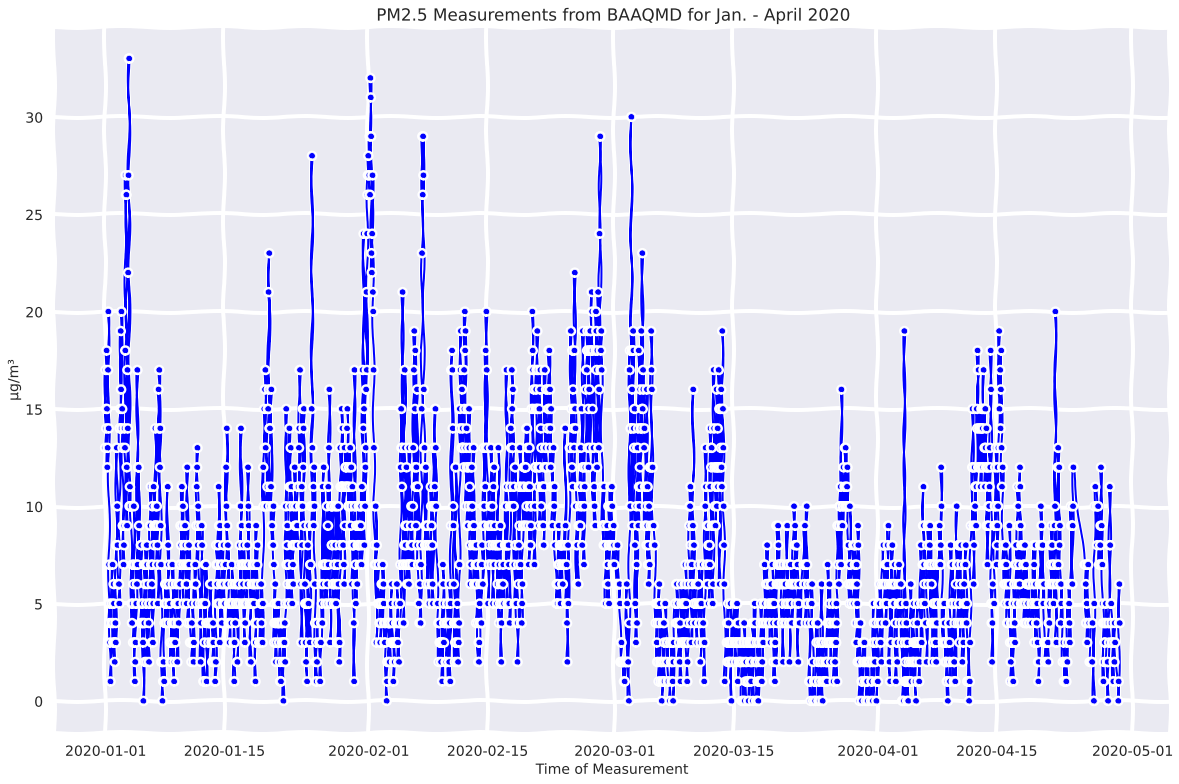

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from matplotlib import *

plt.figure(figsize=(20,13))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=df.index, y="value", data=df, marker='o',alpha=1, color='blue')

    ax = pylab.axes()
    ax.set_title("PM2.5 Measurements from BAAQMD for Jan. - April 2020")

    ax.set_ylabel('µg/m³')
    ax.set_xlabel('Time of Measurement')

#     plt.savefig('assets/')

/home/hp-nunes/dev/repo/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


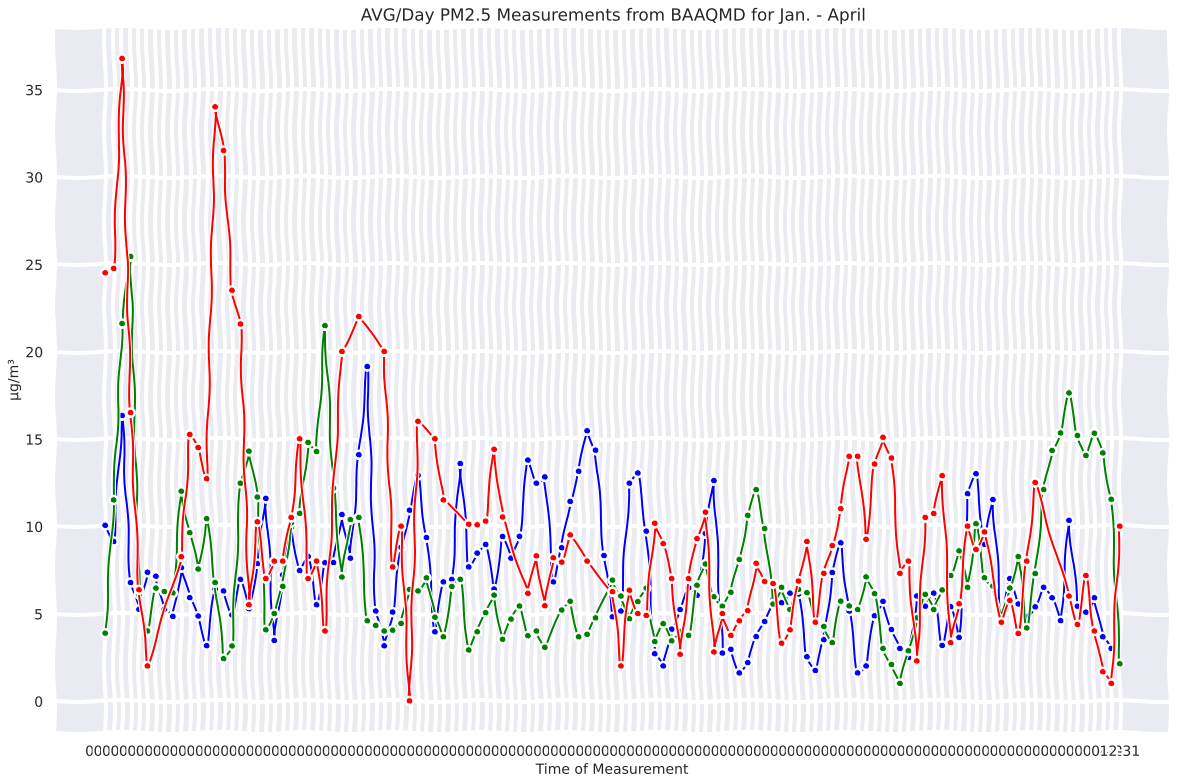

In [203]:
df = pd.read_csv("assets/AirNow_2020.csv")
df['dateTime'] = pd.to_datetime(df['date'])
df.set_index(['dateTime'], inplace = True)


df_19 = pd.read_csv("assets/AirNowdata2019.csv")
df_19['dateTime'] = pd.to_datetime(df_19['date'])
df_19.set_index(['dateTime'], inplace = True)

df_18 = pd.read_csv("assets/AirNowdata2018.csv")
df_18['dateTime'] = pd.to_datetime(df_18['date'])
df_18.set_index(['dateTime'], inplace = True)

# Group by the day

y_day = df['value'].resample('D').mean()
y_day19 = df_19['value'].resample('D').mean()
y_day18 = df_18['value'].resample('D').mean()

y_day.index = y_day.index.map(lambda x: x.strftime('%m-%d'))
y_day19.index = y_day19.index.map(lambda x: x.strftime('%m-%d'))
y_day18.index = y_day18.index.map(lambda x: x.strftime('%m-%d'))

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from matplotlib import *

plt.figure(figsize=(20,13))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=y_day.index, y= y_day, marker='o',alpha=1, color='blue')
    sns.lineplot(x=y_day19.index, y= y_day19, marker='o',alpha=1, color='green')
    sns.lineplot(x=y_day18.index, y= y_day18, marker='o',alpha=1, color='red')

    ax = pylab.axes()
    ax.set_title("AVG/Day PM2.5 Measurements from BAAQMD for Jan. - April")

    ax.set_ylabel('µg/m³')
    ax.set_xlabel('Time of Measurement')

In [207]:
df = df.resample('D').mean()
df.to_csv('assets/AirNowdata2020_24hr.csv')

## PurpleAir Data

In [65]:
    ## Mute one of the import function; do not run both at the same time.

## Import all CSVs into a single DF

path = r'./data_PurpleAir_triage/JantoApril2020' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True, sort=False)


## Import all CSVs into a single DF (rest of April 2020 data)

path = r'./data_PurpleAir_triage/April2020' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True, sort=False)

In [54]:
## Well Crap....the location and geographic coordinates are nested in the file names...
    ## Go to remedy that...

# Import filenames to DF
import glob
import pandas as pd

files = glob.glob('./data_PurpleAir_triage/*.csv')
df = frame

for i, f in enumerate (files):
    if i == 0:
        df = pd.read_csv(f)
        df['fname'] = f
    else:
        tmp = pd.read_csv(f)
        tmp['fname'] = f
        df = df.append(tmp)

df.head()

# Getting the location from the filename
df['location'] = df.fname.str.split('./data_PurpleAir_triage/').str[1].str.split('(').str[0]
# Split Latitude and Longitude into separate fields
df['Longitude'] = df.fname.str.split(')').str[1].str.split('-').str[1]
df['Latitude'] = df.fname.str.split(')').str[1].str.split('-').str[0].str.replace(r'(', '')
# Fixing Coordinate error for certain locations
df.loc[df.location == '25 Short Street _ Kite Hill ', ['Latitude', 'Longitude']] = '37.757645', '-122.44284'
df.loc[df.location == 'Civic Center', ['Latitude', 'Longitude']] = '37.783122', '-122.44284'
df.loc[df.location == 'Synergy School ', ['Latitude', 'Longitude']] = '37.750941', '-122.420312' 
df.loc[df.location == 'Western SoMa ', ['Latitude', 'Longitude']] = '37.774009', '-122.415481' 
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float) * -1
# Sensor location type
df['location_type'] = df.fname.str.split('(').str[1].str.replace(r')', '')

# Fix & format the time fields
df['date'] = df.created_at.str.split(' ').str[0]
df['hour'] = df.created_at.str.split(' ').str[1].str.replace(r'UTC', '')
df['dateTime'] = pd.to_datetime(df['date'] + ' ' + df['hour'])
df = df.sort_values(by='dateTime')
df.set_index(['dateTime'], inplace = True)

# Filter the date range (01/01/20 to 04/17/2020)
import datetime 
df = df.loc[datetime.date(year=2020,month=1,day=1):datetime.date(year=2020,month=4,day=17)]

# Convert UTC to PST
df.index = df.index.tz_localize('UTC').tz_convert('US/Pacific')


# Drop unwanted fields
df= df.drop(['ADC','IAQ','Unnamed: 9','fname','created_at'],axis=1)

# Drop "undefined location types, i.e. only retain locations confirmed interior/outside"
df = df[df.location_type != 'undefined ']

print(df.dtypes)
print(len(df))

df.to_csv('assets/purpleAirdata2020.csv') 

Humidity_%          float64
PM1.0_CF1_ug/m3     float64
PM10.0_CF1_ug/m3    float64
PM2.5_ATM_ug/m3     float64
PM2.5_CF1_ug/m3     float64
Pressure_hpa        float64
RSSI_dbm            float64
Temperature_F       float64
UptimeMinutes       float64
location             object
Longitude           float64
Latitude            float64
location_type        object
date                 object
hour                 object
dtype: object
343779


In [81]:
## April 2020 ## I've downloaded this dataset summarized by 24hr as opposed to 60 mins. FYI. 
# Import filenames to DF
import glob
import pandas as pd

files = glob.glob('./data_PurpleAir_triage/April2020/*.csv')
df = frame

for i, f in enumerate (files):
    if i == 0:
        df = pd.read_csv(f)
        df['fname'] = f
    else:
        tmp = pd.read_csv(f)
        tmp['fname'] = f
        df = df.append(tmp)

df.head()

# Getting the location from the filename
df['location'] = df.fname.str.split('./data_PurpleAir_triage/April2020/').str[1].str.split('(').str[0]
# Split Latitude and Longitude into separate fields
df['Longitude'] = df.fname.str.split(')').str[1].str.split('-').str[1]
df['Latitude'] = df.fname.str.split(')').str[1].str.split('-').str[0].str.replace(r'(', '')
# Fixing Coordinate error for certain locations
df.loc[df.location == '25 Short Street _ Kite Hill ', ['Latitude', 'Longitude']] = '37.757645', '-122.44284'
df.loc[df.location == 'Civic Center', ['Latitude', 'Longitude']] = '37.783122', '-122.44284'
df.loc[df.location == 'Synergy School ', ['Latitude', 'Longitude']] = '37.750941', '-122.420312' 
df.loc[df.location == 'Western SoMa ', ['Latitude', 'Longitude']] = '37.774009', '-122.415481' 
df['Latitude'] = df['Latitude'].astype(float)
df['Longitude'] = df['Longitude'].astype(float) * -1
# # Sensor location type
df['location_type'] = df.fname.str.split('(').str[1].str.replace(r')', '')

# Fix & format the time fields
df['date'] = df.created_at.str.split(' ').str[0]
df['dateTime'] = pd.to_datetime(df['date'])
df = df.sort_values(by='dateTime')
df.set_index(['dateTime'], inplace = True)

import datetime 

# Drop unwanted fields
df= df.drop(['ADC','IAQ','Unnamed: 9','fname','created_at'],axis=1)

# Drop "undefined location types, i.e. only retain locations confirmed interior/outside"
df = df[df.location_type != 'undefined ']

print(df.dtypes)
print(len(df))
df.to_csv('assets/purpleAirdata2020_p2.csv') # concat to purpleAirdata2020.csv below

df.head()

Humidity_%          float64
PM1.0_CF1_ug/m3     float64
PM10.0_CF1_ug/m3    float64
PM2.5_ATM_ug/m3     float64
PM2.5_CF1_ug/m3     float64
Pressure_hpa        float64
RSSI_dbm            float64
Temperature_F       float64
UptimeMinutes       float64
location             object
Longitude           float64
Latitude            float64
location_type        object
date                 object
dtype: object
510


,Humidity_%,PM1.0_CF1_ug/m3,PM10.0_CF1_ug/m3,PM2.5_ATM_ug/m3,PM2.5_CF1_ug/m3,Pressure_hpa,RSSI_dbm,Temperature_F,UptimeMinutes,location,Longitude,Latitude,location_type,date
dateTime,,,,,,,,,,,,,,
2020-04-16,65.05,1.76,5.91,4.64,4.64,NaN,-57.76,60.11,61245.00,Alamo Square,-122.433174,37.775090,outside,2020-04-16
2020-04-16,59.66,3.07,6.83,4.96,5.17,NaN,-53.52,61.68,26941.00,19th St & Guerrero St,-122.424406,37.760688,outside,2020-04-16
2020-04-16,NaN,2.49,6.62,5.05,5.06,1010.77,NaN,NaN,18992.12,Civic Center,122.442840,37.783122,ish B,2020-04-16
2020-04-16,60.36,1.37,4.80,3.19,3.19,NaN,-59.40,61.66,61241.00,Castro,-122.439463,37.761385,outside,2020-04-16
2020-04-16,NaN,1.57,5.88,3.98,3.98,679.76,NaN,NaN,19360.64,25 Short Street _ Kite Hill,122.442840,37.757645,exterior B,2020-04-16


### Formating the DF into unique locations, counts, and averages

In [62]:
df = pd.read_csv("assets/purpleAirdata2020.csv")

In [58]:
# Save DF for every unique location (n=105)
df1 = df.groupby(['Latitude','Longitude','location','location_type']).count().reset_index()
df1 = df1[['Latitude','Longitude','location','location_type','date','PM2.5_ATM_ug/m3']]
df1 = df1.rename(columns={"date": "day_count", "PM2.5_ATM_ug/m3": "measurement_count"})
df2 = df.groupby(['Latitude','Longitude','location','location_type']).mean().reset_index()
df2 = df2[['Latitude','Longitude','Humidity_%','PM2.5_ATM_ug/m3','Temperature_F','UptimeMinutes','PM10.0_CF1_ug/m3','PM1.0_CF1_ug/m3','PM2.5_CF1_ug/m3']]

merged_df = df1.merge(df2, on=['Latitude', 'Longitude'])
merged_df = merged_df.drop_duplicates(subset=['Latitude', 'Longitude','location','location_type'])

len(merged_df) # n=105

merged_df.to_csv('assets/purpleAir_byUniqueLocations.csv')

In [60]:
# Save PurpleAir by summarizing the data by daily measurement for each sensor's unique location.

df['dateTime'] = pd.to_datetime(df['dateTime'])
df = df.sort_values(by='dateTime')
df.set_index(['dateTime'], inplace = True)
df3 = df.groupby(['Latitude','Longitude','location','location_type']).resample('D').mean()
df3.head()

df3.to_csv('assets/purpleAir_TimeseriesDataset.csv')

In [84]:
# Concatenate the two 2020 datasets and drop duplicate times (i.e. @index dateTime)

df_p2 = pd.read_csv("assets/purpleAirdata2020_p2.csv")
df = pd.read_csv("assets/purpleAirdata2020.csv")

df_p2=df_p2.reset_index()
df1=df1.reset_index()
df = df.append(df_p2).drop_duplicates(subset=['dateTime'])
df.set_index(['dateTime'], inplace = True)
# df.to_csv('assets/purpleAir_2020.csv') # Safeguarding the 2020 (Jan-April) dataset

### Timeseries

/home/hp-nunes/dev/repo/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


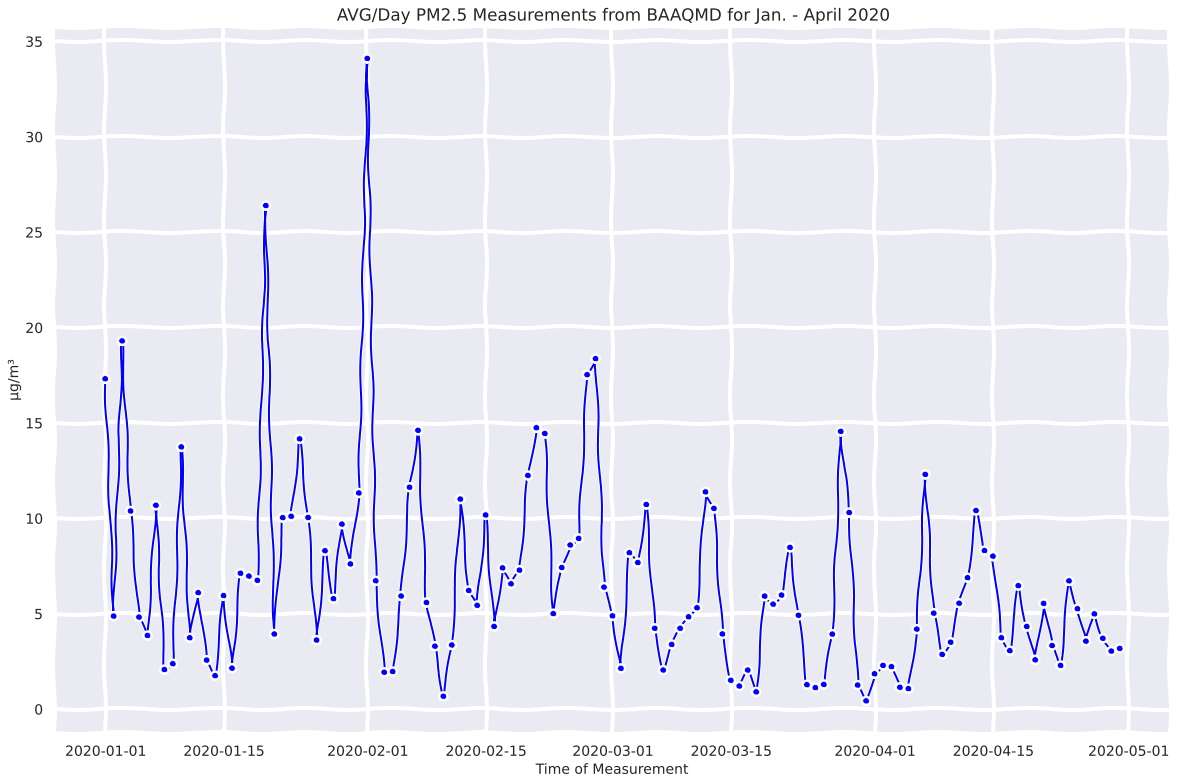

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from matplotlib import *
# Group by the day
df = pd.read_csv("assets/purpleAir_2020.csv")
df1 = df
df1.dateTime = pd.to_datetime(df1.dateTime)
df1.set_index(['dateTime'], inplace = True)
y1_day = df1['PM2.5_ATM_ug/m3'].resample('D').mean()

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from matplotlib import *

plt.figure(figsize=(20,13))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=y1_day.index, y= y1_day, marker='o',alpha=1, color='blue')

    ax = pylab.axes()
    ax.set_title("AVG/Day PM2.5 Measurements from BAAQMD for Jan. - April 2020")

    ax.set_ylabel('µg/m³')
    ax.set_xlabel('Time of Measurement')

## Plotting Comparison

/home/hp-nunes/dev/repo/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


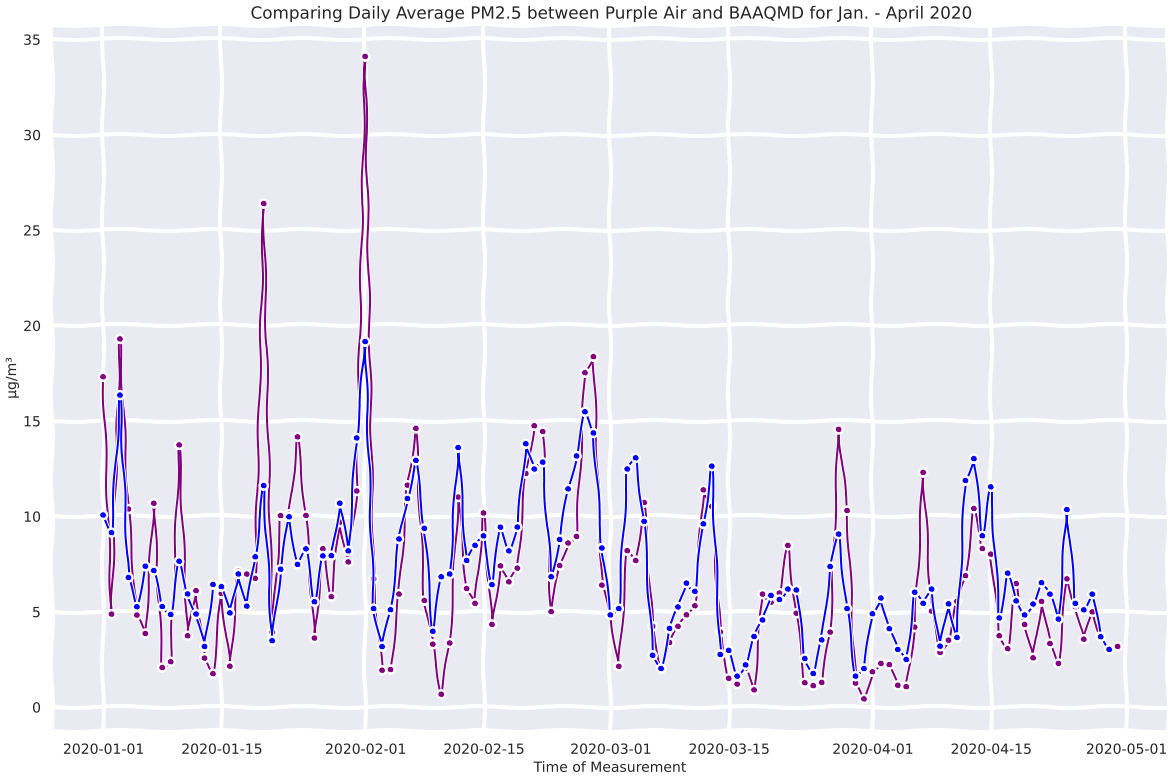

In [86]:
# Plot the AQ and PurpleAir data on the same plot

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from matplotlib import *
# Group by the day

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from matplotlib import *

plt.figure(figsize=(20,13))
with plt.xkcd():
    sns.set_style('darkgrid')
    sns.lineplot(x=y1_day.index, y= y1_day, marker='o',alpha=1, color='purple')
    sns.lineplot(x=y_day.index, y= y_day, marker='o',alpha=1, color='blue')


    ax = pylab.axes()
    ax.set_title("Comparing Daily Average PM2.5 between Purple Air and BAAQMD for Jan. - April 2020")

    ax.set_ylabel('µg/m³')
    ax.set_xlabel('Time of Measurement')
    
    plt.savefig('assets/comparisonPlot')

## HexBin Maps Resources

1) Install NVM first : https://hackernoon.com/how-to-install-node-js-on-ubuntu-16-04-18-04-using-nvm-node-version-manager-668a7166b854
    * Running node v12.16.2 & npm v6.14.4 locally.
    
2) Install TileMill for Ubuntu: https://tilemill-project.github.io/tilemill/docs/linux-install/
    * Medium article: https://blog.mapbox.com/binning-an-alternative-to-point-maps-2cfc7b01d2ed

## R Shiny Dashboard Resources

1) Structure overview of R Shiny: https://rstudio.github.io/shinydashboard/structure.html

2) Interface Component example code: https://shiny.rstudio.com/gallery/dynamic-ui.html

3) Flex Dashboard layout ref: https://rmarkdown.rstudio.com/flexdashboard/

4) Flex Dashboard gallery: https://rmarkdown.rstudio.com/flexdashboard/examples.html

5) Shiny Dashboard gallery: https://rstudio.github.io/shinydashboard/examples.html